In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from sklearn.datasets import make_friedman1
from sklearn.preprocessing import StandardScaler

import os
from pathlib import Path

import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import random


## Data Generation

In [2]:
torch.manual_seed(42)
samples = 10000
n_features = 50

In [3]:
X, y = make_friedman1(n_samples=samples,
                      n_features=n_features,
                      random_state=1,
                      noise=0.0)

x_train, y_train = torch.tensor(X[:7000]).float(), torch.tensor(y[:7000]).unsqueeze(dim=1).float()
x_valid, y_valid = torch.tensor(X[7000:8000]).float(), torch.tensor(y[7000:8000]).unsqueeze(dim=1).float()
x_test, y_test = torch.tensor(X[8000:]).float(), torch.tensor(y[8000:]).unsqueeze(dim=1).float()
   

    
#  Uncomment to check Dataset dimension
print("- x_train size: {}".format(x_train.shape), ", y_train size: {}".format(y_train.shape))
print("- x_valid size: {}".format(x_valid.shape), ", y_valid size: {}".format(y_valid.shape))
print("- x_test size : {}".format(x_test.shape),   " , y_test size: {}".format(y_test.shape))


- x_train size: torch.Size([7000, 50]) , y_train size: torch.Size([7000, 1])
- x_valid size: torch.Size([1000, 50]) , y_valid size: torch.Size([1000, 1])
- x_test size : torch.Size([2000, 50])  , y_test size: torch.Size([2000, 1])


## Normalize Data

In [4]:
def normalize_xy(xtrain, xvalid, xtest, ytrain, yvalid, ytest):
    """
    Input: 
    - Torch tensors with training, validation, and testing data sets 
      (X and Y)
    
    Output:
    - Torch tensors with normalized training, validation, and testing 
      data sets: xtrain, xvalid, xtest, ytrain, yvalid, ytest
        X = (X - X_mean)/X_std
        Y = (Y - Y_mean)/Y_std
    """
    scaler = StandardScaler()
    scaler.fit(xtrain.numpy())
    x_train = torch.from_numpy(scaler.transform(xtrain.numpy()))
    x_valid = torch.from_numpy(scaler.transform(xvalid.numpy()))
    x_test = torch.from_numpy(scaler.transform(xtest.numpy()))
#     
    scaler = StandardScaler()
    scaler.fit(ytrain.numpy())
    y_train = torch.from_numpy(scaler.transform(ytrain.numpy()))
    y_valid = torch.from_numpy(scaler.transform(yvalid.numpy()))
    y_test = torch.from_numpy(scaler.transform(ytest.numpy()))
    return x_train, x_valid, x_test, y_train, y_valid, y_test

In [5]:
# Normalize data
xtrain, xvalid, xtest, ytrain, yvalid, ytest = normalize_xy(x_train, x_valid, x_test, 
                                                            y_train, y_valid, y_test)

# Dataset and Dataloader

In [6]:
class dataset_tabular(Dataset):
    '''
    Input:
    - X values (xtensor) as a 2D torch tensor with dimension 
      [# of points, # of features]
    - Y values (ytensor) as a 1D torch tensor with dimension 
      [# of points,1]
      
    Output:
    - Torch Dataset for tabular data with a single output
    '''
    def __init__(self, xtensor, ytensor):
        self.x = xtensor
        self.y = ytensor
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx,:], self.y[idx], idx


# ==================================================================================================
def make_DataLoaders(xtrain, xvalid, xtest, ytrain, yvalid, ytest, 
                     batch_size=100000, num_workers = 0):
    """
    Input:
    -Torch tensors with xtrain, xvalid, xtest, ytrain, yvalid, ytest
    -Torch Dataset previously defined
    -batch size (integer)
    -Number of CPUs num_workers (integer)
    
    Output:
    -Torch DataLoaders for training, validation, and testing datasets. 
    """
# Create datasets
    train_dataset = dataset_tabular(xtrain, ytrain)
    valid_dataset = dataset_tabular(xvalid, yvalid)
    test_dataset  = dataset_tabular(xtest, ytest)
    
# Create Dataloaders
    train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                                   batch_size = batch_size,
                                                   shuffle = True, 
                                                   num_workers=num_workers)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, 
                                                   batch_size = batch_size,
                                                   shuffle = False, 
                                                   num_workers=num_workers)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                                   batch_size = batch_size,
                                                   shuffle = False, 
                                                   num_workers=num_workers)
    return train_dataloader, valid_dataloader, test_dataloader


In [7]:
# Create dataloaders : 
dl_train, dl_valid, dl_test = make_DataLoaders(xtrain, xvalid, xtest, ytrain, yvalid, ytest, 
                                               batch_size=100000)

In [8]:
## Iterating through a Dataloader object

# print(len(dl_train))
# x,y, idx = next(iter(dl_train))
# idx

# Model

In [9]:
class MyNetwork(nn.Module):    
    def __init__(self):
        """
        Input:
        - n_features
        - hiden layer
        - output layer
        """
        super(MyNetwork, self).__init__()
        self.hidden1 = nn.Linear(n_features,10)
        self.hidden2= nn.Linear(10,10)
        self.hidden3= nn.Linear(10,10)
        self.output = nn.Linear(10,1)
#      self.drop = nn.Dropout(p=0.2)

        
    def forward(self,x):
        x = F.relu(self.hidden1(x))
#       x = self.drop(x)        
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = self.output(x)
        return x

In [10]:
model = MyNetwork()
model

MyNetwork(
  (hidden1): Linear(in_features=50, out_features=10, bias=True)
  (hidden2): Linear(in_features=10, out_features=10, bias=True)
  (hidden3): Linear(in_features=10, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=1, bias=True)
)

# Loss and Optimizer

In [11]:
optimizer = optim.SGD(model.parameters(), lr= 1e-2)
loss_func = nn.MSELoss(reduction='mean')

# Device

In [12]:
# Select type of processor to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cuda'):
    print("-Type of precessor to be used: 'gpu'")
    !nvidia-smi
else:
    print("-Type of precessor to be used: 'cpu'")

-Type of precessor to be used: 'cpu'


# Training

In [13]:
def valid_epoch_reg(data_loader, model, loss_type, device):
    """
    Input:
    - data_loader: torch DataLoader previously created
    - model:       torch model previously trained
    - loss_type:   loss function previously created/instantiated
    - device: 'gpu' or 'cpu'
    
    Output:
    - Mean loss function over the entire data set
    """
# Put model in evaluation mode
    model.eval()
    loss_fun = 0.
    n_points = 0

# Loop over mini batches (no gradients need to be computed)
    with torch.no_grad():
        for i, (xx, yy, _) in enumerate(data_loader, start=1):
            xx = xx.to(device)
            yy = yy.to(device)
            yy_pred = model(xx)
        
# .compute loss function
            batch_size = len(yy)
            loss = loss_type(yy_pred, yy)
            loss_fun += batch_size*loss.item()
        
# .number of points used after the ith mini-batch
            n_points += batch_size
    return loss_fun/n_points

def dataset_r2(data_loader, model, device):
    """
    Input:
    - data_loader: torch DataLoader previously created
    - model:       torch model previously trained
    - device: 'gpu' or 'cpu'
    
    Output:
    - R2 score for the given data set
    """
# Put model in evaluation mode
    model.eval()
    ss_tot = 0.0
    ss_res = 0.0

# Loop over mini batches (no gradients need to be computed)
    with torch.no_grad():
    # .Find mean of y and number of observations
        y_mean = 0.0
        n_points = 0
        for i, (xx, yy, _) in enumerate(data_loader, start=1):
            batch_size = len(yy)
            y_mean += yy.sum()
            n_points += batch_size
        y_mean = y_mean/float(n_points)

    # .Find total sum of squares and residuals
        for i, (xx, yy, _) in enumerate(data_loader, start=1):
            xx = xx.to(device)
            yy = yy.to(device)
            yy_pred = model(xx)

            ss_tot += torch.square(yy - y_mean).sum()
            ss_res += torch.square(yy - yy_pred).sum()

        r2_score = 1.0 - (ss_res/ss_tot)
    return r2_score.item()

In [14]:
# .Loop Over Number of Epochs
iteration = 0
best_loss_valid = np.inf
epochs = 5000
path_loss = {}
data_epoch = []

for n_epoch in range(epochs):
# ..Loop Over Mini-batches
    for ibatch, (xx, yy_true, _) in enumerate(dl_train, start=1):
        
    #...Compute Train Loss (over minibatch)
        model.train()
        xx = xx.to(device)
        yy_true = yy_true.to(device)
        yy_pred = model(xx)
        loss = loss_func(yy_pred, yy_true)
        path_loss['train_loss'] = loss.item()
        
    #...Compute Gradients
        optimizer.zero_grad()
        loss.backward()

    #...Update Weights 
        optimizer.step()
        iteration += 1
        
     #...Compute Validation Loss
        path_loss['valid_loss'] = valid_epoch_reg(dl_valid, 
                                                   model, 
                                                   loss_func, 
                                                   device)   
        
        
        
     #...Compute scores    
        r2_train = r2_score(yy_true.numpy(), yy_pred.detach().numpy())
        r2_valid = dataset_r2(dl_valid, model, device)
        r2_test  = dataset_r2(dl_test, model, device)
        
       
     #...Print training        
        if n_epoch % 500 == 0:
            print(n_epoch, "{:.4f}".format(path_loss['train_loss']), "{:.4f}".format(path_loss['valid_loss']),
                 "Train R2 = {:.3f}".format(r2_train), "Valid R2 = {:.3f}".format(r2_valid),
                 "Test R2 = {:.3f}".format(r2_test))

        
        
     #...File with the loss and r2 per epoch----------------
        data_epoch.append([n_epoch, path_loss['train_loss'], path_loss['valid_loss'],
                           r2_train, r2_valid, r2_test ])                        
        
    
     # ...Check For Validation Minimum
        if path_loss['valid_loss'] < best_loss_valid:
            model_valid_min = copy.deepcopy(model)
            path = "best_model.pth"
            torch.save(model_valid_min.state_dict(), path)
            best_loss_valid = path_loss['valid_loss']
            best_iter_valid = iteration




0 1.0156 1.0243 Train R2 = -0.016 Valid R2 = -0.013 Test R2 = -0.023
500 0.3171 0.3373 Train R2 = 0.683 Valid R2 = 0.666 Test R2 = 0.675
1000 0.2426 0.2667 Train R2 = 0.757 Valid R2 = 0.736 Test R2 = 0.746
1500 0.2211 0.2454 Train R2 = 0.779 Valid R2 = 0.757 Test R2 = 0.764
2000 0.2009 0.2228 Train R2 = 0.799 Valid R2 = 0.780 Test R2 = 0.783
2500 0.1765 0.1956 Train R2 = 0.824 Valid R2 = 0.807 Test R2 = 0.807
3000 0.1459 0.1629 Train R2 = 0.854 Valid R2 = 0.839 Test R2 = 0.838
3500 0.0919 0.1066 Train R2 = 0.908 Valid R2 = 0.895 Test R2 = 0.896
4000 0.0512 0.0630 Train R2 = 0.949 Valid R2 = 0.938 Test R2 = 0.941
4500 0.0435 0.0538 Train R2 = 0.957 Valid R2 = 0.947 Test R2 = 0.950


In [15]:
filename = "reg_output.csv"
columns = ['Epoch', 'Train_loss', 'Val_loss', 'Train_score', 'Val_score', 'Test_score']
df = pd.DataFrame(data=data_epoch, columns=columns)
df.to_csv(filename, index=False)
df.tail(20)

,Epoch,Train_loss,Val_loss,Train_score,Val_score,Test_score
4980,4980,0.039321,0.048160,0.960679,0.952374,0.954702
4981,4981,0.039314,0.048150,0.960686,0.952384,0.954711
4982,4982,0.039307,0.048140,0.960693,0.952394,0.954719
4983,4983,0.039300,0.048129,0.960700,0.952404,0.954728
4984,4984,0.039292,0.048119,0.960708,0.952414,0.954736
4985,4985,0.039285,0.048109,0.960715,0.952424,0.954745
4986,4986,0.039278,0.048099,0.960722,0.952434,0.954753
4987,4987,0.039271,0.048088,0.960729,0.952444,0.954762
4988,4988,0.039264,0.048078,0.960736,0.952454,0.954770
4989,4989,0.039256,0.048068,0.960744,0.952464,0.954779


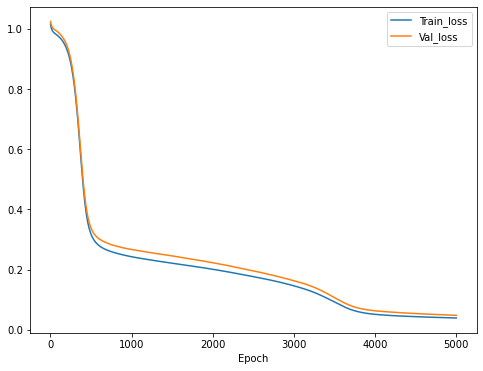

In [16]:
df.plot(x="Epoch", 
        y=['Train_loss', 'Val_loss'], 
        figsize=(8,6))
plt.show()

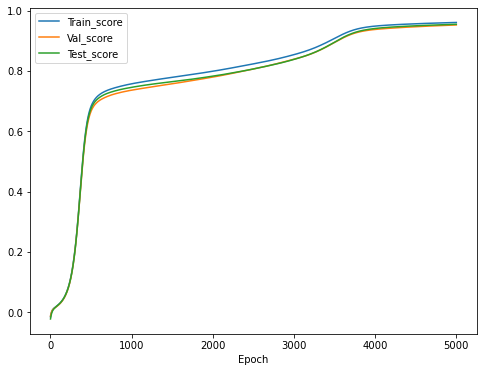

In [17]:
df.plot(x="Epoch", 
        y=['Train_score', 'Val_score', 'Test_score'], 
        figsize=(8,6))
plt.show()